In [2]:
import pandas as pd
import numpy as np
import quandl as qd
import matplotlib.pyplot as plt
import sqlalchemy as db

In [4]:
qd.ApiConfig.api_key = 'xrJsb6qPU-whbsegBjyE'

In [3]:
def get_all_stock():
    con = db.create_engine("sqlite:///C:/Users/zheji/Desktop/TradingTools/dailyDB.sqlite")
    dfs = []
    for table in con.table_names():
        tmp = pd.read_sql(table, con)
        tmp['ticker'] = table
        tmp['1dayret%'] = (tmp['Adj Close'] - tmp['Adj Close'].shift(1))/tmp['Adj Close'].shift(1) * 100
        tmp['nextdayret%'] = (tmp['Adj Close'].shift(-1) - tmp['Adj Close'])/ tmp['Adj Close'] * 100
        dfs.append(tmp)
    return pd.concat(dfs)
stock_df = get_all_stock()

Income Model Factors:
    1. Gross Margin
    2. Net Margin
    3. Revenue Growth
    4. Income Growth
    5. ROE
    6. ROA
    
Balance Sheet Model Factors:
    1. Cash Ratio
    2. Quick Ratio
    3. Current Ratio
    4. Cash/interest expense
    5. Income/interest expense
    6. Cash/all expense


# Define Industry Tickers

In [21]:
#define industry tickers
#can be replaced with config file
airlines = ['DAL','AAL','JBLU','LUV','SAVE','ALK','UAL','AER','AL']
banks = ['C','BAC','MS','JPM','GS','WFC','RY','TD','BNC']
casinos = ['MGM','WYNN','MLCO','BYD','LVS','CZR','ERI','PENN']
hotels = ['MAR','HLT','EXPE','TCOM','H','IHG','CHH','WH','WYND','PK']
online_fur = ['W', 'OSTK']
good_stocks = ['AAPL', 'FB', 'GOOGL']
online_shopping = ['SHOP', 'W', 'PDD', 'AMZN', 'CRM', 'FSLY']
chinese = ['PDD', 'JD', 'BABA']
utilities = ['DUK', 'NEE', 'D', 'SO', 'AEP', 'EXC', 'SRE', 'XEL', 'WEC', 'ES']
cyber = ['CRWD', 'PANW', 'SPLK', 'CSCO', 'AVGO', 'ZS', 'OKTA', 'FTNT', 'VMW', 'AKAM']
interest = ['FLIR']

In [14]:
def single_stock(stock, choice):
    df = qd.get_table('SHARADAR/SF1',dimension='MRY',ticker=stock)
    if choice == 'income':
        return analyze_income(df)
    if choice == 'debt':
        return analyze_debt(df)
    
def analyze_debt(df):
    debt = df
    #print(debt)
    debt['cash_ratio'] = debt['cashneq']/debt['liabilitiesc']
    debt['quick_ratio'] = (debt['cashneq'] + debt['investmentsc'])/debt['liabilitiesc']
    debt['current_ratio'] = debt['assetsc'] / debt['liabilitiesc']
    debt['cash_intexp'] = debt['cashneq'] / (debt['intexp']+1)
    debt['cash_allexp'] = debt['cashneq'] / (debt['intexp'] + debt['opex'])
    debt['cash_ncfdebt'] = debt['cashneq'] / (debt['ncfdebt'] + 1)
    debt['inc_intexp'] = debt['netinc']/(debt['intexp']+1)
    debt['cashsc_pershare'] = (debt['cashneq'] + debt['investmentsc']) / debt['sharesbas']
    debt['cash_pershare'] = (debt['cashneq']) / debt['sharesbas']
    debt['book_pershare'] = debt['equityusd'] / debt['sharesbas']
    ret_cols = ['book_pershare','cash_ratio','quick_ratio','current_ratio','inc_intexp','cash_intexp','cash_allexp','cash_ncfdebt','reportperiod','ticker', 'cashsc_pershare', 'cash_pershare']
    return debt[ret_cols]

def analyze_income(df):
    inc_cols = ['revenue','netinc','sgna','rnd','opex','grossmargin','netmargin','ebitdamargin','roe','roa','reportperiod','ticker', 'sharesbas', 'operatingmargin']
    inc = df
    inc['sales_pershare'] = inc['revenue'] / inc['sharesbas']
    inc['rev_growth'] = (inc['revenue']-inc['revenue'].shift(1))/inc['revenue'].shift(1) * 100
    inc['income_growth'] = (inc['netinc']-inc['netinc'].shift(1))/inc['netinc'].shift(1) * 100
    inc['ebitda_growth'] = (inc['ebitda']-inc['ebitda'].shift(1))/inc['ebitda'].shift(1) * 100
    inc['operatingmargin'] = inc['opinc']/inc['revenue']
    print(inc)
    inc['median_income_growth'] = inc['income_growth'].rolling(12).median()
    inc['mean_income_growth'] = inc['income_growth'].rolling(12).mean()
    inc['median_ebitda_growth'] = inc['ebitda_growth'].rolling(12).median()
    inc['mean_ebitda_growth'] = inc['ebitda_growth'].rolling(12).mean()
    inc['median_rev_growth'] = inc['rev_growth'].rolling(12).median()
    inc['mean_rev_growth'] = inc['rev_growth'].rolling(12).mean()
    ret_cols = inc_cols + ['sales_pershare', 'ebitda_growth', 'mean_ebitda_growth', 'median_ebitda_growth','rev_growth','income_growth', 'median_income_growth', 'mean_income_growth', 'median_rev_growth', 'mean_rev_growth']
    return inc[ret_cols]

def get_data(industry):
    dfs = {'income':{}, 'debt': {}}
    for stock in industry:
        df = qd.get_table('SHARADAR/SF1',dimension='MRY',ticker=stock)
        df = df.sort_values('reportperiod')
        df.index = df.reportperiod
        tmp = analyze_debt(df)
        #tmp['reportperiod'] = pd.to_datetime(tmp['reportperiod'])
        #tmp = tmp.sort_values('reportperiod')
        #tmp.index = tmp['reportperiod']
        if tmp.shape[0]!=0:
            dfs['debt'][stock] = tmp
            del tmp['reportperiod']
        
        tmp = analyze_income(df)
        #tmp['reportperiod'] = pd.to_datetime(tmp['reportperiod'])
        #tmp = tmp.sort_values('reportperiod')
        #tmp.index = tmp['reportperiod']
        if tmp.shape[0]!=0:
            dfs['income'][stock] = tmp
            del tmp['reportperiod']
    return dfs


def analyze_industry_cross(dfs,choice,metric):
    tmp = pd.DataFrame()
    df = dfs[choice]
    for k, v in df.items():
        tmp[k] = v[metric]
    tmp.plot(figsize=(20,10))
    plt.show()
# def analyze_industry_prior(dfs, choice):
#     df = dfs[choice]
#     for k, v in df.items():
#         # v is a df
#         df
def analyze_industry_current(dfs, choice):
    df = dfs[choice]
    lst = [df[k].iloc[-1,:] for k in df.keys()]
    tmp = pd.concat(lst, axis=1).T
    #print(tmp)
    tmp.index = tmp.ticker
    del tmp['ticker']
    print(tmp)
def get_current_metric(stocks):
    df = qd.get_table('SHARADAR/DAILY', date='2020-06-24')
    return df[df['ticker'].isin(stocks)]

In [22]:
dfs = get_data(online_shopping) #get fundamentalt data for stocks within the industry

             ticker dimension calendardate    datekey reportperiod  \
reportperiod                                                         
2015-12-31     SHOP       MRY   2015-12-31 2015-12-31   2015-12-31   
2016-12-31     SHOP       MRY   2016-12-31 2016-12-31   2016-12-31   
2017-12-31     SHOP       MRY   2017-12-31 2017-12-31   2017-12-31   
2018-12-31     SHOP       MRY   2018-12-31 2018-12-31   2018-12-31   
2019-12-31     SHOP       MRY   2019-12-31 2019-12-31   2019-12-31   

             lastupdated    accoci      assets   assetsavg     assetsc  ...  \
reportperiod                                                            ...   
2015-12-31    2020-06-08         0   243712000   169452500   202465000  ...   
2016-12-31    2020-06-08  -1818000   490558000   368321000   422898000  ...   
2017-12-31    2020-06-08   3435000  1113564000   948385750  1025677000  ...   
2018-12-31    2020-06-08 -12216000  2254785000  1922018000  2129082000  ...   
2019-12-31    2020-06-08   1046000 

             ticker dimension calendardate    datekey reportperiod  \
reportperiod                                                         
2016-01-31      CRM       MRY   2015-12-31 2016-01-31   2016-01-31   
2017-01-31      CRM       MRY   2016-12-31 2017-01-31   2017-01-31   
2018-01-31      CRM       MRY   2017-12-31 2018-01-31   2018-01-31   
2019-01-31      CRM       MRY   2018-12-31 2019-01-31   2019-01-31   
2020-01-31      CRM       MRY   2019-12-31 2020-01-31   2020-01-31   

             lastupdated    accoci       assets    assetsavg      assetsc  \
reportperiod                                                                
2016-01-31    2020-06-01 -49917000  12762920000  11208636250   5731323000   
2017-01-31    2020-06-01 -75841000  17584923000  14792794000   5996827000   
2018-01-31    2020-06-01 -12000000  21984000000  18487942250   9584000000   
2019-01-31    2020-06-01 -58000000  30737000000  26527750000  10683000000   
2020-01-31    2020-06-01 -93000000  55126000000

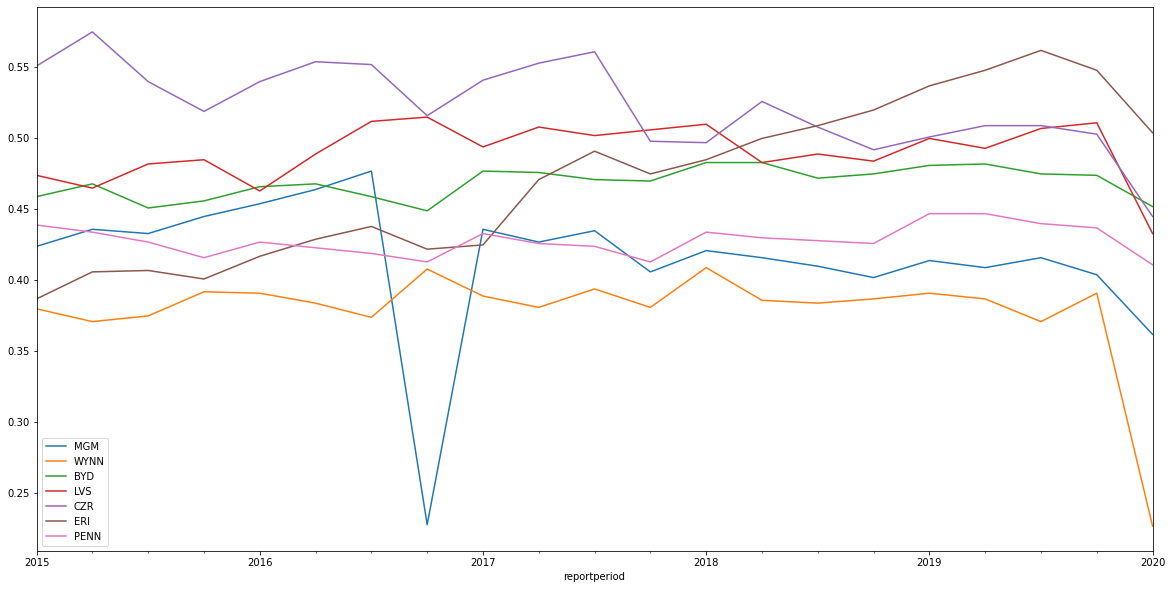

In [44]:
analyze_industry_cross(dfs,'income','grossmargin')

In [20]:
analyze_industry_current(dfs,'debt')

       book_pershare cash_ratio quick_ratio current_ratio   inc_intexp  \
ticker                                                                   
SHOP         26.1457    2.05421     7.76022       8.67536 -1.24842e+08   
W           -10.1385   0.361617    0.612469      0.854559     -18.0611   
PDD         0.757293   0.728588     1.49963       1.59504     -47.7698   
AMZN         125.172   0.411014    0.626577       1.09705       7.2425   
CRM          38.2018   0.279219    0.535332       1.07531     1.26e+08   

        cash_intexp cash_allexp cash_ncfdebt cashsc_pershare cash_pershare  
ticker                                                                      
SHOP    6.49916e+08    0.645533  6.49916e+08          21.286       5.63462  
W             10.69    0.186077     0.623168         10.5981       6.25737  
PDD         228.619     1.02643      4.24199          14.762       7.17203  
AMZN        22.5575    0.353687     -3.58554         110.975       72.7959  
CRM       4.145e+09

In [ ]:
get_current_metric(interest)

In [23]:
analyze_industry_current(dfs,'income')

             revenue       netinc         sgna          rnd          opex  \
ticker                                                                      
SHOP      1578173000   -124842000    651775000    355015000    1006790000   
W         9127057000   -984584000   2720546000            0    3077273000   
PDD      30141886000  -6967603000  28470961000   3870358000   32341319000   
AMZN    280522000000  11588000000  24081000000  35931000000  100445000000   
CRM      17098000000    126000000   9634000000   2766000000   12566000000   
FSLY       200462000    -51550000    112196000     46492000     158688000   

       grossmargin netmargin ebitdamargin    roe    roa  ... sales_pershare  \
ticker                                                   ...                  
SHOP         0.549    -0.079       -0.038 -0.049 -0.043  ...        13.6824   
W            0.235    -0.108        -0.08  1.453 -0.384  ...        98.0028   
PDD           0.79    -0.231       -0.203 -0.277 -0.114  ...       

In [ ]:
single_stock('PK','income')